# PySpark Data Processing Tutorial

**Project**: PySpark ETL  
**Technologies**: PySpark, Python, SQL  
**Source**: [Portfolio Internal](Portfolio Internal)

---

## Executive Summary

Comprehensive guide to batch data processing with PySpark, covering DataFrames, SQL queries, window functions, and performance optimization.

---


In [1]:
# Cell: comprobaciones de entorno
import sys, shutil, subprocess

print("Python:", sys.version.splitlines()[0])

java = shutil.which("java")
if java:
    try:
        out = subprocess.check_output([java, "-version"], stderr=subprocess.STDOUT)
        print(out.decode(errors='ignore').splitlines()[0])
    except Exception as e:
        print("Error ejecutando 'java -version':", e)
else:
    print("No se encontró 'java' en PATH. PySpark necesita Java (OpenJDK 11/17 recomendado).")

try:
    import pyspark
    print("pyspark:", pyspark.__version__)
except Exception:
    print("pyspark no instalado. Ejecuta la celda de instalación si quieres instalarlo.")


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
java version "17.0.12" 2024-07-16 LTS
pyspark: 3.5.1


---

## 2) Instalación (ejecutar solo si hace falta)

> Ejecuta esto SOLO si `pyspark` no está instalado. Ajusta versiones si lo deseas.


In [2]:
# Cell: instalar paquetes (Windows/Linux/macOS)
import sys

print("Usando Python:", sys.executable)
!"{sys.executable}" -m pip install --upgrade pip
!"{sys.executable}" -m pip install pyspark==3.5.1 pandas matplotlib --quiet
print("Instalación finalizada. Reinicia el kernel si se indica.")
!pip -V
!python -V

Usando Python: C:\Users\soyko\AppData\Local\Programs\Python\Python310\python.exe
Instalación finalizada. Reinicia el kernel si se indica.
pip 25.3 from C:\Users\soyko\AppData\Local\Programs\Python\Python310\lib\site-packages\pip (python 3.10)

Python 3.10.11


**Consejo**: en Windows, si instalas el JDK, añade la carpeta `bin` de JAVA_HOME al PATH y reinicia el terminal / kernel.

---

## 3) Crear SparkSession (segura para notebooks) 



In [3]:
# Cell: crear SparkSession con manejo
from pyspark.sql import SparkSession
from pyspark import SparkConf
import os

conf = SparkConf()
conf.set("spark.sql.shuffle.partitions", "8")  # ajusta a tu CPU
conf.set("spark.driver.memory", "2g")

try:
    spark = SparkSession.builder.appName("PySpark-Interactive-Notebook").config(conf=conf).getOrCreate()
    print("SparkSession creada. master=", spark.sparkContext.master, "version=", spark.version)
except Exception as e:
    print("Error creando SparkSession:", e)

# Si necesitas parar al final del notebook:
# spark.stop()


SparkSession creada. master= local[*] version= 3.5.1


### Asegurarnos de que Spark y los workers usan exactamente el mismo intérprete Python

In [4]:
import os, sys

# Forzar que los workers usen el mismo python que el kernel
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Opciones útiles para debugging local
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.sql.shuffle.partitions=2 pyspark-shell"

print("PYSPARK_PYTHON:", os.environ["PYSPARK_PYTHON"])
print("python executable:", sys.executable)

# Reiniciar/crear SparkSession seguro
try:
    from pyspark.sql import SparkSession
    if 'spark' in globals():
        try:
            spark.stop()
        except Exception:
            pass
    spark = SparkSession.builder \
        .master("local[2]") \
        .appName("debug_pyspark") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.sql.shuffle.partitions", "2") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    print("Spark started:", spark.version, spark.sparkContext.master)
except Exception as e:
    print("ERROR al crear SparkSession:", repr(e))
    raise


PYSPARK_PYTHON: C:\Users\soyko\AppData\Local\Programs\Python\Python310\python.exe
python executable: C:\Users\soyko\AppData\Local\Programs\Python\Python310\python.exe
Spark started: 3.5.1 local[2]


## Testeamos un hola mundo

In [5]:
df = spark.createDataFrame([(1,"a"), (2,"b"), (3,"c")], ["id","v"])
print("count:", df.count())
print("collect:", df.select("v").rdd.map(lambda r: r[0].upper()).collect())
df.show()

count: 3
collect: ['A', 'B', 'C']
+---+---+
| id|  v|
+---+---+
|  1|  a|
|  2|  b|
|  3|  c|
+---+---+



**Por qué:** establecer `shuffle.partitions` y `driver.memory` en el notebook hace que los trabajos pequeños no generen demasiados fragmentos.

---

## 4) DataFrame desde lista — ejemplo y operaciones básicas


In [6]:
# Cell: ejemplo pequeño
import os, sys
from pyspark.sql import functions as F

data = [
    ("Alice", "2025-01-01", 50.0),
    ("Bob",   "2025-01-01", 20.0),
    ("Alice", "2025-01-02", 30.0),
    ("Bob",   "2025-01-02", 40.0),
    ("Carmen","2025-01-02", 15.0)
]

columns = ["name", "date", "amount"]
# Puedes forzar tipos con schema si lo deseas (pyspark.sql.types)
df = spark.createDataFrame(data, schema=columns)
df.show()
df.printSchema()

# Filtrar
print('\\nFiltrando amount > 25:')
df.filter(F.col('amount') > 25).show()

# Agrupar y agregar
agg = df.groupBy('name').agg(
    F.count('*').alias('n_trx'),
    F.sum('amount').alias('total_amount'),
    F.avg('amount').alias('avg_amount')
).orderBy(F.desc('total_amount'))
agg.show()


+------+----------+------+
|  name|      date|amount|
+------+----------+------+
| Alice|2025-01-01|  50.0|
|   Bob|2025-01-01|  20.0|
| Alice|2025-01-02|  30.0|
|   Bob|2025-01-02|  40.0|
|Carmen|2025-01-02|  15.0|
+------+----------+------+

root
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- amount: double (nullable = true)

\nFiltrando amount > 25:
+-----+----------+------+
| name|      date|amount|
+-----+----------+------+
|Alice|2025-01-01|  50.0|
|Alice|2025-01-02|  30.0|
|  Bob|2025-01-02|  40.0|
+-----+----------+------+

+------+-----+------------+----------+
|  name|n_trx|total_amount|avg_amount|
+------+-----+------------+----------+
| Alice|    2|        80.0|      40.0|
|   Bob|    2|        60.0|      30.0|
|Carmen|    1|        15.0|      15.0|
+------+-----+------------+----------+



---

## 5) Leer/Escribir CSV y Parquet (ejemplo reproducible)
*Crear CSV de ejemplo y leerlo con Spark*

In [7]:

import pandas as pd
sample_csv = 'sample_data.csv'
pd.DataFrame([
    {'name':'Alice','date':'2025-01-01','amount':50},
    {'name':'Bob','date':'2025-01-01','amount':20},
    {'name':'Carmen','date':'2025-01-03','amount':70},
]).to_csv(sample_csv, index=False)

# Leer CSV con Spark (más seguro: especificar schema en producción)
df_csv = spark.read.option('header', True).option('inferSchema', True).csv(sample_csv)
df_csv.show()

df_csv.printSchema()
print('Count:', df_csv.count())

df_csv.describe('amount').show()

# Escribir Parquet particionado por 'date'
out_dir = 'out_parquet_example'
df_csv.write.mode('overwrite').partitionBy('date').parquet(out_dir)
print('Escrito parquet en:', out_dir)

# Leer de nuevo
from pathlib import Path
if Path(out_dir).exists():
    df_parq = spark.read.parquet(out_dir)
    df_parq.show()
else:
    print('Directorio no encontrado:', out_dir)


+------+----------+------+
|  name|      date|amount|
+------+----------+------+
| Alice|2025-01-01|    50|
|   Bob|2025-01-01|    20|
|Carmen|2025-01-03|    70|
+------+----------+------+

root
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: integer (nullable = true)

Count: 3
+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|                 3|
|   mean|46.666666666666664|
| stddev|25.166114784235834|
|    min|                20|
|    max|                70|
+-------+------------------+

Escrito parquet en: out_parquet_example
+------+------+----------+
|  name|amount|      date|
+------+------+----------+
|Carmen|    70|2025-01-03|
| Alice|    50|2025-01-01|
|   Bob|    20|2025-01-01|
+------+------+----------+



**Explicación rápida del particionado:** particionar por columnas con bajas cardinalidades (ej. `year`, `date`) mejora lecturas filtradas, pero no abuses con columnas de alta cardinalidad.

---

## 6) Joins y broadcast join para tablas desiguales


In [8]:
# Cell: joins
customers = spark.createDataFrame([('Alice','A1'),('Bob','B1'),('Carmen','C1')], ['name','cust_id'])
transactions = df  # ejemplo anterior

# Join normal
joined = transactions.join(customers, on='name', how='left')
joined.show()

# Si customers es pequeño, usar broadcast para evitar shuffle
from pyspark.sql.functions import broadcast
joined_b = transactions.join(broadcast(customers), on='name', how='left')
joined_b.show()


+------+----------+------+-------+
|  name|      date|amount|cust_id|
+------+----------+------+-------+
| Alice|2025-01-01|  50.0|     A1|
|   Bob|2025-01-01|  20.0|     B1|
| Alice|2025-01-02|  30.0|     A1|
|   Bob|2025-01-02|  40.0|     B1|
|Carmen|2025-01-02|  15.0|     C1|
+------+----------+------+-------+

+------+----------+------+-------+
|  name|      date|amount|cust_id|
+------+----------+------+-------+
| Alice|2025-01-01|  50.0|     A1|
|   Bob|2025-01-01|  20.0|     B1|
| Alice|2025-01-02|  30.0|     A1|
|   Bob|2025-01-02|  40.0|     B1|
|Carmen|2025-01-02|  15.0|     C1|
+------+----------+------+-------+



---

## 7) Caché / persistencia y explain


In [9]:
agg.cache()  # o agg.persist(StorageLevel.MEMORY_ONLY)
print('Plan físico:')
agg.explain(True)

# Después de usarlo
agg.unpersist()


Plan físico:
== Parsed Logical Plan ==
'Sort ['total_amount DESC NULLS LAST], true
+- Aggregate [name#21], [name#21, count(1) AS n_trx#57L, sum(amount#23) AS total_amount#59, avg(amount#23) AS avg_amount#61]
   +- LogicalRDD [name#21, date#22, amount#23], false

== Analyzed Logical Plan ==
name: string, n_trx: bigint, total_amount: double, avg_amount: double
Sort [total_amount#59 DESC NULLS LAST], true
+- Aggregate [name#21], [name#21, count(1) AS n_trx#57L, sum(amount#23) AS total_amount#59, avg(amount#23) AS avg_amount#61]
   +- LogicalRDD [name#21, date#22, amount#23], false

== Optimized Logical Plan ==
InMemoryRelation [name#21, n_trx#57L, total_amount#59, avg_amount#61], StorageLevel(disk, memory, deserialized, 1 replicas)
   +- AdaptiveSparkPlan isFinalPlan=false
      +- Sort [total_amount#59 DESC NULLS LAST], true, 0
         +- Exchange rangepartitioning(total_amount#59 DESC NULLS LAST, 2), ENSURE_REQUIREMENTS, [plan_id=501]
            +- HashAggregate(keys=[name#21], functi

DataFrame[name: string, n_trx: bigint, total_amount: double, avg_amount: double]

**Recordatorio:** cachea solo cuando vas a reusar un DataFrame varias veces y si hay memoria libre.

---

## 8) toPandas y visualización (advertencia de memoria)


     name  n_trx  total_amount  avg_amount
0   Alice      2          80.0        40.0
1     Bob      2          60.0        30.0
2  Carmen      1          15.0        15.0


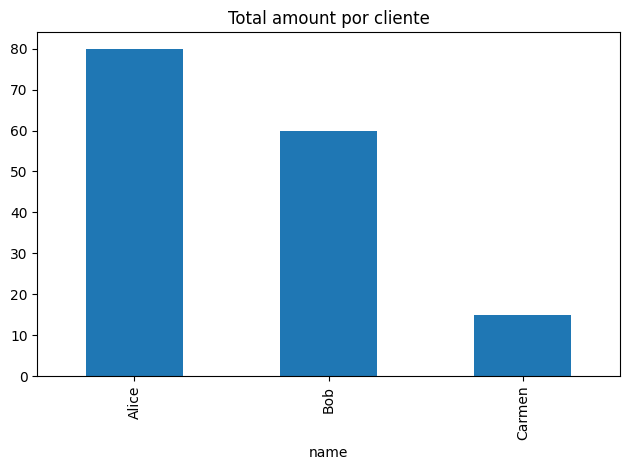

In [10]:
pdf = agg.toPandas()
print(pdf)

import matplotlib.pyplot as plt
pdf.plot.bar(x='name', y='total_amount', legend=False)
plt.title('Total amount por cliente')
plt.tight_layout()
plt.show()


> `toPandas()` trae todo a memoria local; evita en datasets grandes.

---

## 9) Buenas prácticas y pasos siguientes

- Evita `inferSchema` en producción: define `StructType` si necesitas control de tipos.
- Para I/O masiva usa rutas `s3://` o `hdfs://` y habilita credenciales apropiadas.
- Usa `explain()` y la Spark UI (por defecto en `http://localhost:4040` mientras el driver esté activo) para entender shuffles.
- Para streaming: mira `Structured Streaming` (readStream / writeStream).
- Para ML: `pyspark.ml` ofrece pipelines y transformers; usa `VectorAssembler` y `Pipeline`.

---

## 10) Plantilla de finalización (parar Spark)


In [11]:
spark.stop()
print('Spark detenido')


Spark detenido


---

## Problemas comunes y soluciones rápidas

- **No se encuentra java**: instala JDK, establece `JAVA_HOME` y añade `bin` al `PATH`.
- **Permisos con setx en Windows**: ejecuta PowerShell/Command Prompt como Administrador.
- **`pyspark` import error**: revisa que `pip` instaló en el mismo Python que usa el kernel.

---

Si quieres, puedo convertir este documento en un **.ipynb** real que puedas descargar y abrir en Jupyter, o bien adaptarlo a tu dataset concreto (ponme la ruta o describe la estructura de los ficheros y preparo las celdas de ETL/transformación).
